# Package Imports

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf

# Data Loader

In [5]:
def get_data(stocks, start, end):
    stockData = yf.download(
        stocks,
        start=start,
        end=end,
        auto_adjust=True,
        progress=False
    )['Close']
    
    returns = stockData.pct_change().dropna()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    
    return meanReturns, covMatrix

In [6]:
stock_list = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
stocks = [stock for stock in stock_list]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*3)

# The Math

In [7]:
meanReturns, covMatrix = get_data(stocks, startDate, endDate)

**Portfolio Weights:**

$$ \sum w_i = 1$$

**Correlated Asset Returns via Cholesky Decomposition:**

$$\Sigma = L \times L^T \text{ (Cholesky factorization)}$$

$$R_{daily} = \mu + L \times Z \text{ where } Z \sim N(0,1)$$

The Cholesky decomposition is critical for realistic simulations. In real markets, assets don't move independently—stocks in the same sector tend to rise and fall together. The covariance matrix Σ captures these relationships, but we can't directly sample from it. 

Instead, we generate independent standard normal random variables (Z) and transform them using the Cholesky factor (L). This linear transformation L×Z creates correlated returns that preserve the exact correlation structure from the historical covariance matrix. Adding the mean returns (μ) centers the distribution at expected values, giving us realistic daily returns for each asset that move together as they would in actual markets.

**Portfolio Daily Return:**

$$R_{portfolio}(t) = \sum (w_i \times R_i(t))$$

**Cumulative Portfolio Value:**

$$V(t) = V_0 \times \prod_{\tau=1}^{t}(1 + R_{portfolio}(\tau))$$

T = 252 trading days across 10,000 scenarios with correlated asset dynamics.

In [8]:
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

# Monte Carlo  Method to simulate portfolio performance
num_simultations = 10000
T = 252
meanMatrix = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanMatrix = meanMatrix.T

portfolio_simulations = np.full(shape=(T, num_simultations), fill_value=0.0)

initialPortfolioValue = 10000

for m in range(0,num_simultations):
    Z = np.random.normal(size = (T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanMatrix + np.inner(L, Z)
    portfolio_simulations[:,m] = np.cumprod(np.inner(weights, dailyReturns.T) + 1) * initialPortfolioValue

# Simulation Plot

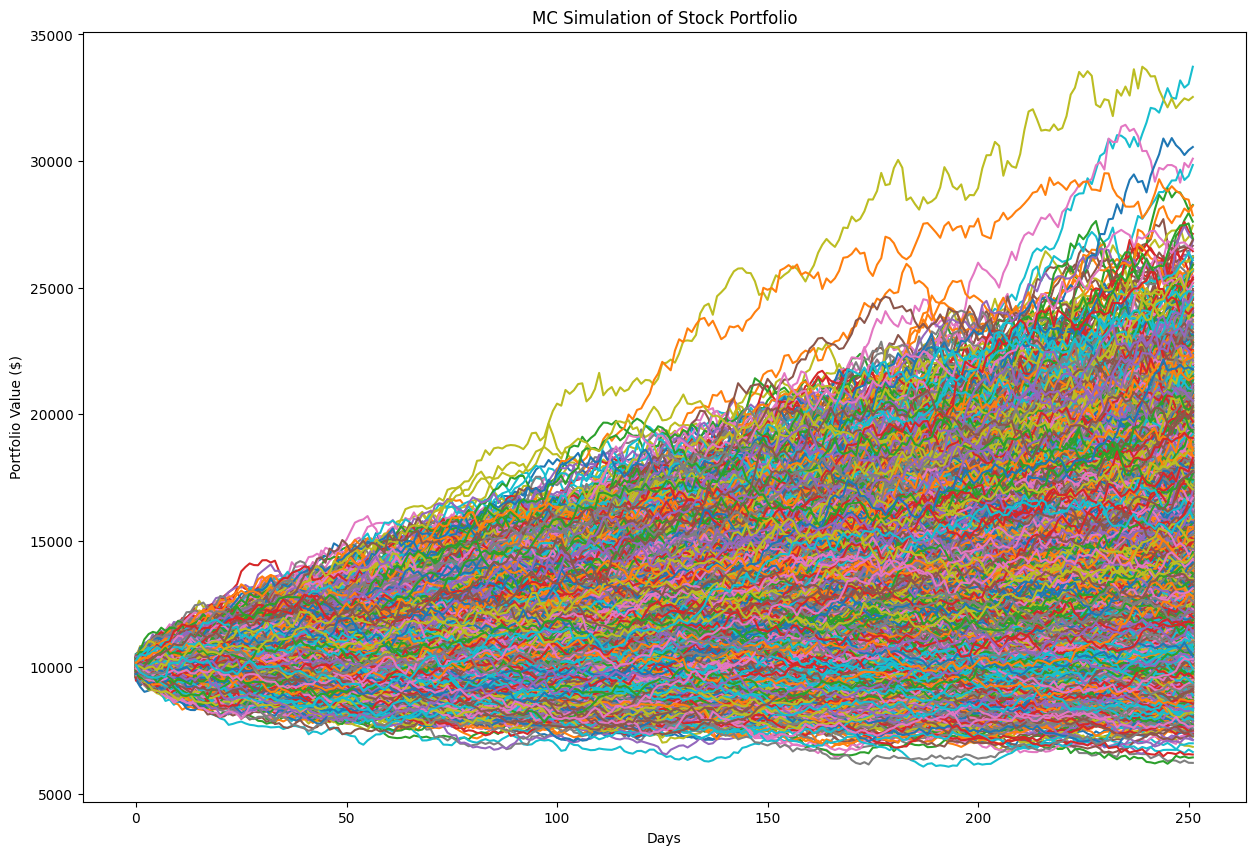

In [9]:
plt.figure(figsize=(15,10))  
plt.plot(portfolio_simulations)
plt.xlabel('Days')
plt.ylabel('Portfolio Value ($)')
plt.title('MC Simulation of Stock Portfolio')
plt.show()


# VaR and CVaR (Expected Shortfall)

In [10]:
def mcVaR(returns, alpha = 5):
    """
    Input: pandas series of returns
    Output: percentile on return distribution to a given confidence level alpha

    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected returns to be a pandas Series")

def mcCVaR(returns, alpha = 5):
    """
    Input: pandas series of returns
    Output: CVaR or Expected Shortfall to a given confidence level alpha

    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha = alpha)
        return returns[belowVaR].mean()

    else:
        raise TypeError("Expected returns to be a pandas Series")

portResults  = pd.Series(portfolio_simulations[-1,:])

VaR = initialPortfolioValue - mcVaR(portResults, alpha=5)
CVaR = initialPortfolioValue - mcCVaR(portResults, alpha=5)

print(f"5% VaR: ${VaR:.2f}")
print(f"5% CVaR: ${CVaR:.2f}")

5% VaR: $200.70
5% CVaR: $1004.48


What this is saying is basically, 95% chance losses won't exceed $200.70 over 252 days. However, in the worst 5% of scenarios 500 out of 10,000 simulations, average loss is $1,004.48